<font size=5> This document includes or references data provided by J.P. Morgan. </font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)

In [2]:
JPfraud_full = pd.read_csv("../data/fraud_payment_data")
JPfraud_full

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498173,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498174,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498175,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [3]:
# Removing $0 transactions, which contain no fraud labels
JPfraud_full = JPfraud_full[JPfraud_full.USD_amount > 0].reset_index(level=0,drop=True)

In [4]:
len(JPfraud_full[JPfraud_full.USD_amount == 0])

0

In [5]:
JPfraud_full = JPfraud_full.drop(columns=['Sender_lob'],axis=1)
JPfraud_full['timestamp'] = pd.to_datetime(JPfraud_full['Time_step'],format='%Y-%m-%d %H:%M:%S')
JPfraud_full = JPfraud_full.drop(columns=['Time_step'])
JPfraud_full.insert(0,'timestamp',JPfraud_full.pop('timestamp'))
JPfraud_full

,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498151,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498152,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498153,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [6]:
JPfraud = JPfraud_full
JPfraud

,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498151,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498152,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498153,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [7]:
type(JPfraud_full.timestamp.iloc[12345])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
len(set(JPfraud_full.Sender_Account.unique()).union(set(JPfraud_full.Bene_Account.unique())))

305416

In [9]:
JPfraud.Transaction_Type.value_counts()

Transaction_Type
MAKE-PAYMENT     557713
QUICK-PAYMENT    217607
MOVE-FUNDS       180205
DEPOSIT-CHECK    109477
DEPOSIT-CASH     109409
EXCHANGE         108167
PAY-CHECK        107851
WITHDRAWAL       107726
Name: count, dtype: int64

In [10]:
len(set(JPfraud_full.Sender_Account.unique()).union(set(JPfraud_full.Bene_Account.unique())))

305416

In [11]:
JPfraud.Label.value_counts(normalize=True)

Label
0    0.979429
1    0.020571
Name: proportion, dtype: float64

In [12]:
print(JPfraud.Sender_Id.value_counts())
print()
print(JPfraud.Bene_Id.value_counts())

Sender_Id
JPMC-CLIENT-1730807     157
JPMC-CLIENT-1869649     155
JPMC-CLIENT-303611      155
JPMC-CLIENT-360470      154
JPMC-CLIENT-1613778     153
                       ... 
BILL-COMPANY-2185550      1
BILL-COMPANY-2181010      1
JPMC-CLIENT-4789          1
BILL-COMPANY-1132738      1
BILL-COMPANY-2178781      1
Name: count, Length: 59071, dtype: int64

Bene_Id
JPMC-CLIENT-1119942     80
JPMC-CLIENT-1939718     79
JPMC-CLIENT-730151      79
JPMC-CLIENT-599198      79
JPMC-CLIENT-198756      78
                        ..
BILL-COMPANY-2181407     1
BILL-COMPANY-2182036     1
BILL-COMPANY-2182042     1
BILL-COMPANY-2177637     1
BILL-COMPANY-2179998     1
Name: count, Length: 279341, dtype: int64


In [13]:
# Do unique accounts have multiple Sender or Beneficiary countries?
sender_pairs = JPfraud[['Sender_Id','Sender_Country']].dropna().drop_duplicates()
sender_pairs.sort_values(by='Sender_Id',inplace=True,ascending=True)
sender_pairs = sender_pairs.reset_index(drop=True)
sender_pairs

,Sender_Id,Sender_Country
0,BILL-COMPANY-100003,USA
1,BILL-COMPANY-1000050,USA
2,BILL-COMPANY-1000221,MOLDOVA
3,BILL-COMPANY-1000505,USA
4,BILL-COMPANY-1000532,UNITED-ARAB-EMIRATES
...,...,...
62724,JPMC-COMPANY-998531,GERMANY
62725,JPMC-COMPANY-998831,GERMANY
62726,JPMC-COMPANY-999378,GERMANY
62727,JPMC-COMPANY-999590,GERMANY


In [14]:
sender_pairs[sender_pairs.duplicated(subset='Sender_Id',keep=False)]

,Sender_Id,Sender_Country
42141,JPMC-CLIENT-1000741,USA
42142,JPMC-CLIENT-1000741,MOLDOVA
42143,JPMC-CLIENT-1001025,NAURU
42144,JPMC-CLIENT-1001025,USA
42146,JPMC-CLIENT-1001310,USA
...,...,...
57249,JPMC-CLIENT-999092,USA
57253,JPMC-CLIENT-999586,USA
57254,JPMC-CLIENT-999586,MONGOLIA
57255,JPMC-CLIENT-999641,USA


In [15]:
len(JPfraud.Transaction_Id.unique())

1498155

<font size=8>Checking for which transactions have NaNs </font>

In [16]:
JPfraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498155 entries, 0 to 1498154
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   timestamp         1498155 non-null  datetime64[ns]
 1   Transaction_Id    1498155 non-null  object        
 2   Sender_Id         1279269 non-null  object        
 3   Sender_Account    1279269 non-null  object        
 4   Sender_Country    1279269 non-null  object        
 5   Sender_Sector     1279269 non-null  float64       
 6   Bene_Id           1282262 non-null  object        
 7   Bene_Account      1282262 non-null  object        
 8   Bene_Country      1282262 non-null  object        
 9   USD_amount        1498155 non-null  float64       
 10  Label             1498155 non-null  int64         
 11  Transaction_Type  1498155 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 137.2+ MB


In [17]:
JPfraud.isna().sum()

timestamp                0
Transaction_Id           0
Sender_Id           218886
Sender_Account      218886
Sender_Country      218886
Sender_Sector       218886
Bene_Id             215893
Bene_Account        215893
Bene_Country        215893
USD_amount               0
Label                    0
Transaction_Type         0
dtype: int64

In [18]:
# Indicating only depositing transactions have NaN's for Sender_Id
JPfraud[((JPfraud.Sender_Id.isnull()) & ~((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]

,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type


In [19]:
print('Number of DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK'))]))
print('Number of NaNs in Sender_Id for DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Sender_Id.isna()) & ((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]))

Number of DEPOSIT-CASH, DEPOSIT-CHECK transactions 218886
Number of NaNs in Sender_Id for DEPOSIT-CASH, DEPOSIT-CHECK transactions 218886


In [20]:
print('Number of WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                             (JPfraud.Transaction_Type == 'EXCHANGE'))]))
print('Number of nulls in Bene_Id for WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Bene_Id.isnull()) &
                                                                                            ((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                                                                             (JPfraud.Transaction_Type == 'EXCHANGE')))]))

Number of WITHDRAWAL, EXCHANGE transactions 215893
Number of nulls in Bene_Id for WITHDRAWAL, EXCHANGE transactions 215893


<font size=4> **Conclusion:** *There's not any "missing data." Deposits (DEPOSIT-CASH, DEPOSIT-CHECK) only have Beneficiary account identifications, and withdrawals/exchanges only have Sender account identifications.*</font>

<font size=6> Comparing transaction amount and number of fraudulent transactions detected </font>

In [21]:
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))
non_fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()
    non_fraud_number[i] = len(JPfraud[JPfraud.Label == 0].loc[JPfraud.Transaction_Type == trans])

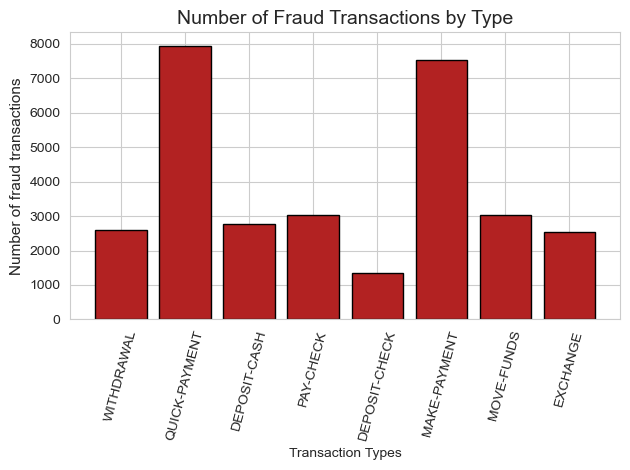

In [25]:
plt.figure()

plt.bar(trans_types, fraud_number, edgecolor='black', color='firebrick')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of fraud transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)
plt.title('Number of Fraud Transactions by Type',fontsize=14)
plt.tight_layout()
plt.savefig('Fraud_number_vs_transaction_types.png')
plt.show()

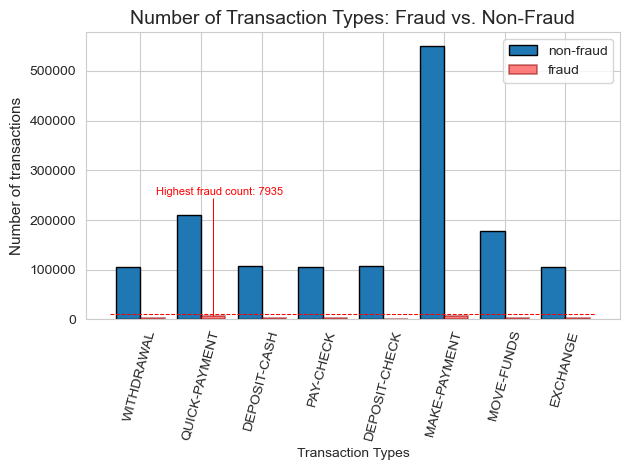

In [23]:
plt.figure()

w = 0.4

plt.bar(np.arange(len(trans_types))-w/2, non_fraud_number, label='non-fraud', edgecolor='black', width=w)
plt.bar(np.arange(len(trans_types))+w/2, fraud_number, alpha = 0.5, color='red', width=w,
        label='fraud', edgecolor='darkred', linewidth=1.2)
plt.hlines(y=fraud_number[1]+2038, xmin=-0.5, xmax=len(trans_types)-0.5,
           linewidth=0.75, color='red', linestyle='--')
plt.vlines(x=1.2, ymin=fraud_number[1], ymax=245000,
           linewidth=0.75, color='red', linestyle='-')
plt.text(0.25,250000, 'Highest fraud count: 7935', fontsize=8, color='red')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)), trans_types, rotation=75)
plt.title('Number of Transaction Types: Fraud vs. Non-Fraud',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('fraud_and_non-fraud_vs_transaction_types.png')
plt.show()

In [21]:
print('Max USD amount:', JPfraud.USD_amount.max())
print('Min USD amount:', JPfraud.USD_amount.min())

Max USD amount: 19998.94
Min USD amount: 0.01


In [22]:
JPfraud.loc[JPfraud.Label == 1].USD_amount.describe()

count    30819.000000
mean       847.442043
std       2003.566402
min        100.000000
25%        254.115000
50%        512.230000
75%        773.975000
max      19998.940000
Name: USD_amount, dtype: float64

In [36]:
JPfraud.loc[JPfraud.Label == 0].USD_amount.describe()

count    489799.000000
mean        507.138052
std         462.090546
min           0.010000
25%         135.870000
50%         402.020000
75%         733.340000
max       19838.380000
Name: USD_amount, dtype: float64

In [37]:
bin_labels = []
for i in np.arange(40):
    bin_labels.append(str(i*500) + '-' + str(i*500 + 500))

print(bin_labels)
print()
print(len(bin_labels))

['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-3500', '3500-4000', '4000-4500', '4500-5000', '5000-5500', '5500-6000', '6000-6500', '6500-7000', '7000-7500', '7500-8000', '8000-8500', '8500-9000', '9000-9500', '9500-10000', '10000-10500', '10500-11000', '11000-11500', '11500-12000', '12000-12500', '12500-13000', '13000-13500', '13500-14000', '14000-14500', '14500-15000', '15000-15500', '15500-16000', '16000-16500', '16500-17000', '17000-17500', '17500-18000', '18000-18500', '18500-19000', '19000-19500', '19500-20000']

40


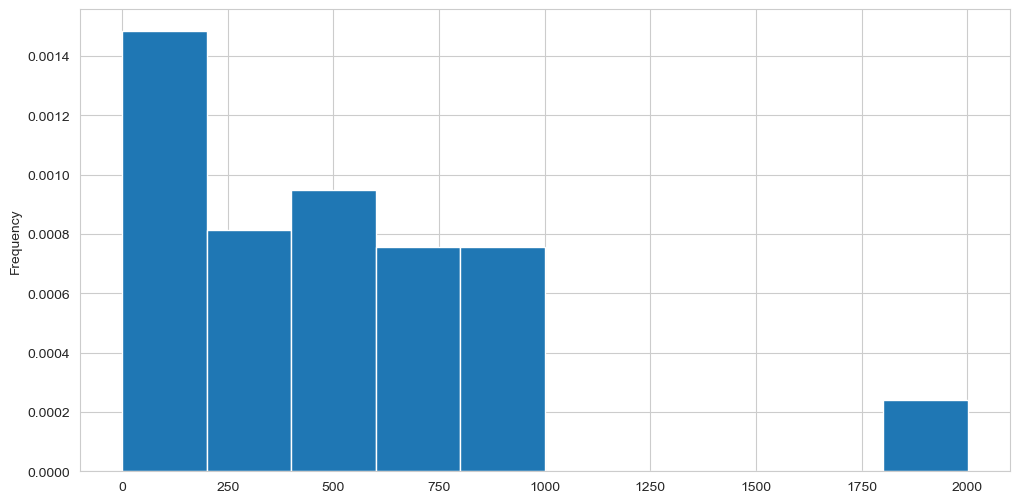

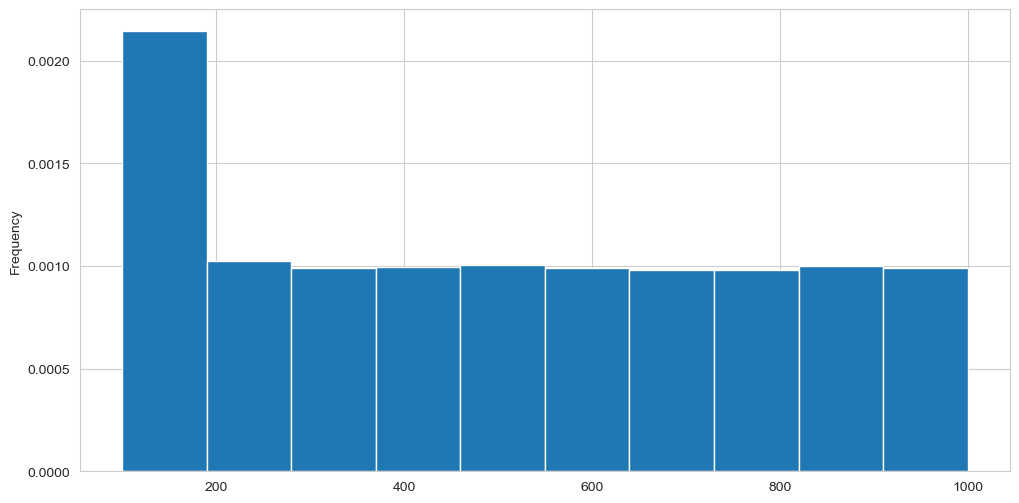

In [46]:
plt.figure(figsize=(12,6))
JPfraud.loc[JPfraud.USD_amount < 2500].USD_amount.plot.hist(bins=10, density=True)
plt.show()

plt.figure(figsize=(12,6))
JPfraud[JPfraud.Label == 1].loc[JPfraud.USD_amount < 2500].USD_amount.plot.hist(bins=10, density=True)
plt.show()

<font size=6> Distribution of time </font>

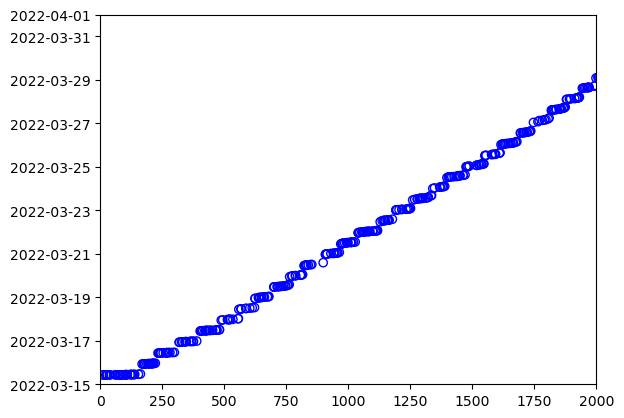

In [40]:
plt.figure()
JPfraud_timeplot = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot.index,JPfraud_timeplot.timestamp,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([0,2000])
plt.ylim([dt.datetime(2022,3,15,0,0,0),dt.datetime(2022,4,1,0,0,0)])
plt.show()

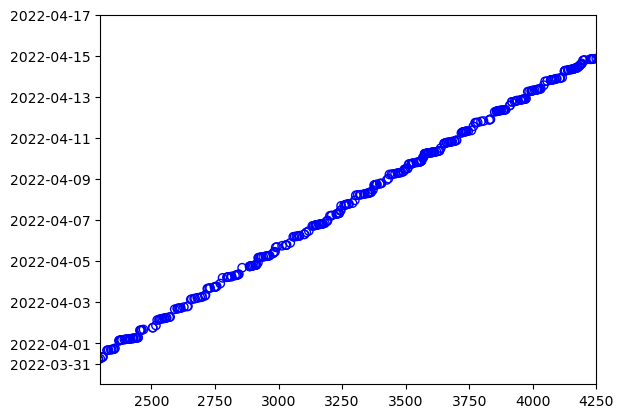

In [41]:
plt.figure()
JPfraud_timeplot2 = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot2.index,JPfraud_timeplot2.timestamp,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([2300,4250])
plt.ylim([dt.datetime(2022,3,30,0,0,0),dt.datetime(2022,4,17,0,0,0)])
plt.show()

In [42]:
JPfraud.timestamp.value_counts().head(40)

timestamp
2023-08-28 13:04:09    100
2027-10-12 02:14:35    100
2024-08-09 12:34:15     99
2024-10-09 01:34:16     99
2029-01-13 17:34:43     99
2030-08-11 02:14:53     99
2023-03-04 07:34:06     99
2027-08-15 12:14:34     98
2022-11-04 17:04:04     98
2031-11-09 18:55:01     98
2028-11-17 15:24:42     98
2032-10-22 07:15:07     98
2029-05-09 22:14:45     98
2027-12-10 14:34:36     97
2027-02-27 15:54:31     97
2023-06-29 11:54:08     97
2023-04-29 11:04:07     97
2028-02-06 16:24:37     97
2028-05-31 21:24:39     97
2031-05-24 00:54:58     97
2030-02-21 07:24:50     96
2024-02-16 18:14:12     96
2031-09-12 18:05:00     96
2030-06-14 00:24:52     96
2027-04-24 19:24:32     96
2026-01-18 14:34:24     96
2026-05-13 07:44:26     96
2031-07-20 03:04:59     96
2023-12-21 16:04:11     96
2032-03-04 10:45:03     96
2028-04-04 19:14:38     96
2026-07-09 21:44:27     96
2029-09-02 14:04:47     96
2030-04-19 09:44:51     96
2029-07-07 11:54:46     96
2029-12-27 04:54:49     96
2026-09-06 23:14:2

<font size=6> Behavioral Features </font>

**Goal:** Identify patterns from a client’s transaction history.

Transaction Amount Patterns:
<ul><li> Average transaction amount per client </li>
<li> Deviations from typical amounts (outliers) </li>
</ul>

Transaction Timing Patterns:
<ul>
 <li>  Unusual activity by local time (time zone outliers for the client) </li>
 <li> Time between consecutive transactions, </li>
 <li> Recipient Patterns: Number of unique recipients per sender (potential pattern for laundering) </li>
</ul>

<font size=6> Attempting rolling day stats</font>

In [43]:
rolling_period = '180D'
min_obs = 3

In [48]:
# Calculates time between previous transaction for each of seller, beneficiary
# (The mask.....etc code sets the sender_time_btwn, bene_time_btwn feature to 0 (of timedelta type)
# for the first occurrence an account appears. NaT's are still placed where a Sender_Account or
# Bene_Account entry is NaN.)

JPfraud['sender_time_btwn'] = (JPfraud.groupby('Sender_Account')['timestamp'].diff()
                                      .mask(JPfraud.groupby('Sender_Account')['timestamp'].cumcount().eq(0), dt.timedelta(0))
                              )
JPfraud['bene_time_btwn'] = (JPfraud.groupby('Bene_Account')['timestamp'].diff()
                                    .mask(JPfraud.groupby('Bene_Account')['timestamp'].cumcount().eq(0), dt.timedelta(0))
                            )

JPfraud

,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,sender_time_btwn,bene_time_btwn
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,WITHDRAWAL,0 days 00:00:00,NaT
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,0 days 00:00:00,0 days 00:00:00
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,NaT,0 days 00:00:00
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,0 days 00:00:00,0 days 00:00:00
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,NaT,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT,1 days 00:20:00,28 days 06:40:00
1498151,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT,0 days 12:00:00,6 days 13:30:00
1498152,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT,0 days 12:00:00,0 days 00:00:00
1498153,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT,0 days 12:00:00,0 days 12:00:00


In [45]:
type(JPfraud.sender_time_btwn[0])

pandas._libs.tslibs.timedeltas.Timedelta

In [46]:
# Testing that new features are computing correctly
JPfraud[JPfraud.Sender_Account == 'ACCOUNT-9825']

,timestamp_uniq,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,sender_time_btwn,bene_time_btwn
3,2022-03-15 10:24:00.000000003,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,0 days 00:00:00,0 days 00:00:00
137,2022-03-15 10:54:00.000000137,2022-03-15 10:54:00,PAY-BILL-9836,JPMC-CLIENT-9812,ACCOUNT-9825,USA,2871.0,COMPANY-9815,ACCOUNT-9821,USA,393.89,0,MAKE-PAYMENT,0 days 00:30:00,0 days 00:00:00
365,2022-03-16 23:24:00.000000365,2022-03-16 23:24:00,CASH-CHECK-9843,JPMC-CLIENT-9812,ACCOUNT-9825,USA,16185.0,NaN,NaN,NaN,207.50,0,EXCHANGE,1 days 12:30:00,NaT
442,2022-03-17 11:34:00.000000442,2022-03-17 11:34:00,QUICK-PAYMENT-9842,JPMC-CLIENT-9812,ACCOUNT-9825,USA,30716.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,100.02,0,QUICK-PAYMENT,0 days 12:10:00,1 days 12:10:00
517,2022-03-17 23:34:00.000000517,2022-03-17 23:34:00,WITHDRAWAL-9845,JPMC-CLIENT-9812,ACCOUNT-9825,USA,2041.0,NaN,NaN,NaN,685.63,0,EXCHANGE,0 days 12:00:00,NaT
525,2022-03-17 23:44:00.000000525,2022-03-17 23:44:00,PAY-BILL-9846,JPMC-CLIENT-9812,ACCOUNT-9825,USA,11960.0,COMPANY-9815,ACCOUNT-9821,USA,854.45,0,MAKE-PAYMENT,0 days 00:10:00,2 days 12:50:00
753,2022-03-19 13:14:00.000000753,2022-03-19 13:14:00,QUICK-PAYMENT-9865,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38842.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,930.23,0,QUICK-PAYMENT,1 days 13:30:00,0 days 00:10:00
755,2022-03-19 13:24:00.000000755,2022-03-19 13:24:00,EXCHANGE-9866,JPMC-CLIENT-9812,ACCOUNT-9825,USA,19558.0,NaN,NaN,NaN,100.26,0,EXCHANGE,0 days 00:10:00,NaT
759,2022-03-19 13:54:00.000000759,2022-03-19 13:54:00,MOVE-FUNDS-9869,JPMC-CLIENT-9812,ACCOUNT-9825,USA,13635.0,JPMC-COMPANY-9819,ACCOUNT-9830,LIBERIA,232.31,0,MOVE-FUNDS,0 days 00:30:00,0 days 00:00:00
760,2022-03-19 14:04:00.000000760,2022-03-19 14:04:00,EXCHANGE-9870,JPMC-CLIENT-9812,ACCOUNT-9825,USA,34203.0,NaN,NaN,NaN,204.88,0,WITHDRAWAL,0 days 00:10:00,NaT


In [47]:
JPfraud[JPfraud.Bene_Account == 'ACCOUNT-10041'].head(25)

,timestamp_uniq,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,sender_time_btwn,bene_time_btwn
4789,2022-04-19 02:44:00.000004789,2022-04-19 02:44:00,PAYMENT-10039,JPMC-CLIENT-9812,ACCOUNT-9825,USA,35961.0,BILL-COMPANY-10040,ACCOUNT-10041,USA,44.13,0,MAKE-PAYMENT,1 days 12:40:00,0 days


<font size=5> Issues/Questions:</font>
<ol>
    <li> For a new client, first few transactions will likely be outside of quartile ranges.
         Maybe do not have quantile ranges until after first 90, 180 etc days? </li>
    <li> Treat out_range classifiers differently for NaN's? </li>
    <li> </li>
</ol>

In [48]:
JPfraud.sender_time_btwn.describe()

count                       427177
mean     1 days 08:50:09.365672777
std      2 days 02:34:59.497194269
min                0 days 00:00:00
25%                0 days 00:30:00
50%                0 days 12:10:00
75%                1 days 12:50:00
max               52 days 13:10:00
Name: sender_time_btwn, dtype: object

In [49]:
# Number of non-fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('1h').Label.count()

sender_time_btwn
0 days 00:00:00     184679
0 days 01:00:00        860
0 days 02:00:00          2
0 days 03:00:00          0
0 days 04:00:00          0
                     ...  
52 days 09:00:00         0
52 days 10:00:00         0
52 days 11:00:00         0
52 days 12:00:00         0
52 days 13:00:00         1
Freq: h, Name: Label, Length: 1262, dtype: int64

In [50]:
# Number of fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1h').Label.count().head(40)

sender_time_btwn
0 days 00:00:00    4168
0 days 01:00:00      66
0 days 02:00:00       1
0 days 03:00:00       0
0 days 04:00:00       0
0 days 05:00:00       0
0 days 06:00:00       0
0 days 07:00:00       0
0 days 08:00:00       0
0 days 09:00:00       0
0 days 10:00:00       0
0 days 11:00:00       0
0 days 12:00:00    2568
0 days 13:00:00      93
0 days 14:00:00       2
0 days 15:00:00       0
0 days 16:00:00       0
0 days 17:00:00       0
0 days 18:00:00       0
0 days 19:00:00       0
0 days 20:00:00       0
0 days 21:00:00       0
0 days 22:00:00       0
0 days 23:00:00       5
1 days 00:00:00    1050
1 days 01:00:00     113
1 days 02:00:00       4
1 days 03:00:00       0
1 days 04:00:00       0
1 days 05:00:00       0
1 days 06:00:00       0
1 days 07:00:00       0
1 days 08:00:00       0
1 days 09:00:00       0
1 days 10:00:00       0
1 days 11:00:00       3
1 days 12:00:00     479
1 days 13:00:00     119
1 days 14:00:00       3
1 days 15:00:00       0
Freq: h, Name: Label, d

In [51]:
# Number of fraud, sender transactions vs time between transactions, 5 minute-distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('5min').Label.sum().head(25)

# Note: shows data generated only on 10-minute increments

sender_time_btwn
0 days 00:00:00       0
0 days 00:05:00       0
0 days 00:10:00    2703
0 days 00:15:00       0
0 days 00:20:00     814
0 days 00:25:00       0
0 days 00:30:00     406
0 days 00:35:00       0
0 days 00:40:00     167
0 days 00:45:00       0
0 days 00:50:00      78
0 days 00:55:00       0
0 days 01:00:00      35
0 days 01:05:00       0
0 days 01:10:00      17
0 days 01:15:00       0
0 days 01:20:00       7
0 days 01:25:00       0
0 days 01:30:00       5
0 days 01:35:00       0
0 days 01:40:00       1
0 days 01:45:00       0
0 days 01:50:00       1
0 days 01:55:00       0
0 days 02:00:00       1
Freq: 5min, Name: Label, dtype: int64

In [52]:
# Number of sender fraudulent transactions within 24 hours (inclusive) of a transaction
print('Number of sender frauds within first hour after transaction: ', JPfraud[JPfraud.sender_time_btwn <= dt.timedelta(hours=1)].Label.sum())
print('Number of sender frauds within 13 hours after transaction: ', JPfraud[JPfraud.sender_time_btwn <= dt.timedelta(hours=13)].Label.sum())
print('Number of sender frauds over 13 hours after transaction: ', JPfraud[JPfraud.sender_time_btwn > dt.timedelta(hours=13)].Label.sum())
print('Number of sender fraud committed exactly 12 hours after:', JPfraud[JPfraud.sender_time_btwn == dt.timedelta(hours=12)].Label.sum())

Number of sender frauds within first hour after transaction:  2847
Number of sender frauds within 13 hours after transaction:  5483
Number of sender frauds over 13 hours after transaction:  3362
Number of sender fraud committed exactly 12 hours after: 446


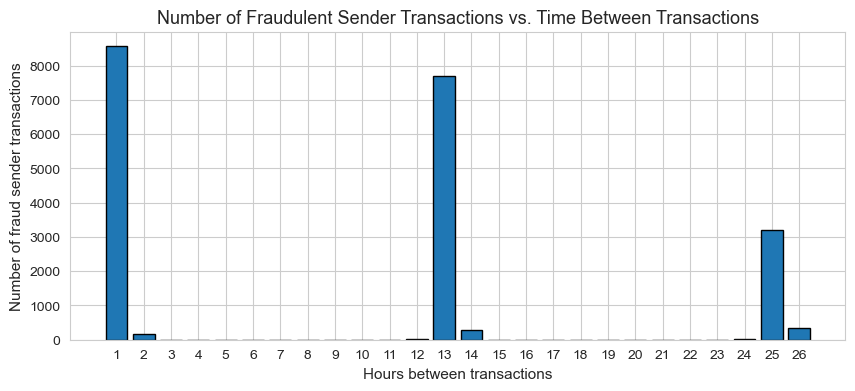

In [65]:
# Plotting distribution of sender fraud counts in hours after transaction
trans_btwn_counts = np.zeros(26)

for i in np.arange(26):
    trans_btwn_counts[i] = JPfraud[((JPfraud.sender_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.sender_time_btwn < dt.timedelta(hours=float(i+1))))].Label.sum()

plt.figure(figsize=(10,4))
plt.bar(np.linspace(1,26,26), trans_btwn_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of fraud sender transactions',fontsize=11)
plt.title('Number of Fraudulent Sender Transactions vs. Time Between Transactions',fontsize=14)
plt.xticks(np.arange(26)+1)
plt.savefig('sender_hrs_after_fraud.png')
plt.show()

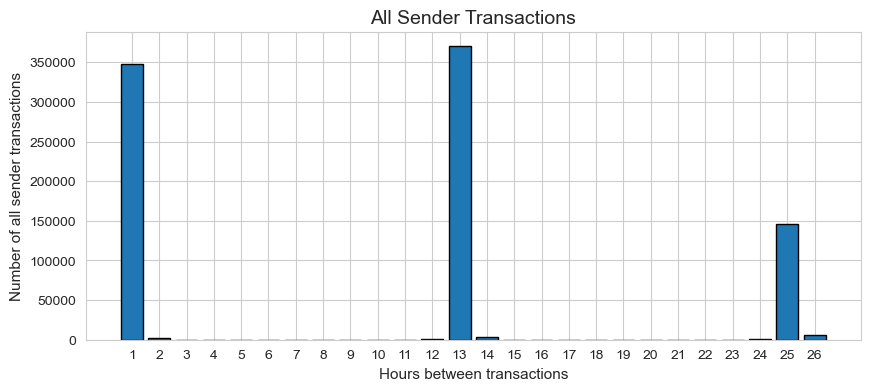

In [73]:
# Plotting distribution of sender fraud counts in hours after transaction
all_trans_btwn_counts = np.zeros(26)

for i in np.arange(26):
    all_trans_btwn_counts[i] = len(JPfraud[((JPfraud.sender_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.sender_time_btwn < dt.timedelta(hours=float(i+1))))])

plt.figure(figsize=(10,4))
plt.bar(np.linspace(1,26,26), all_trans_btwn_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of all sender transactions',fontsize=11)
plt.xticks(np.arange(26)+1)
plt.title('All Sender Transactions',fontsize=14)
plt.savefig('sender_hrs_btwn_all_transactions.png')
plt.show()


In [55]:
# Number of bene fraudulent transactions within 24 hours (inclusive) of a transaction
print('Number of bene frauds within first hour after transaction: ', JPfraud[JPfraud.bene_time_btwn <= dt.timedelta(hours=1)].Label.sum())
print('Number of bene frauds within 25 hours after transaction: ', JPfraud[JPfraud.bene_time_btwn <= dt.timedelta(hours=25)].Label.sum())
print('Number of bene frauds over 25 hours after transaction: ', JPfraud[JPfraud.bene_time_btwn > dt.timedelta(hours=25)].Label.sum())

Number of bene frauds within first hour after transaction:  2865
Number of bene frauds within 25 hours after transaction:  4956
Number of bene frauds over 25 hours after transaction:  3536


In [56]:
trans_btwn_counts

array([2.812e+03, 6.600e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.568e+03, 9.300e+01, 2.000e+00, 0.000e+00])

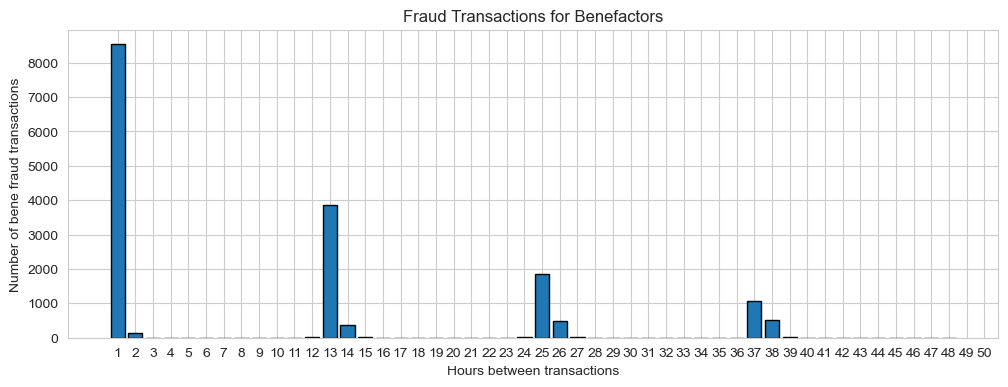

In [72]:
# Plotting distribution of bene fraud counts in hours after transaction
trans_btwn_bene_counts = np.zeros(48)

for i in np.arange(48):
    trans_btwn_bene_counts[i] = JPfraud[((JPfraud.bene_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.bene_time_btwn < dt.timedelta(hours=float(i+1))))].Label.sum()

plt.figure(figsize=(12,4))
plt.bar(np.linspace(1,48,48), trans_btwn_bene_counts, edgecolor='black')
plt.xlabel('Hours between transactions')
plt.ylabel('Number of bene fraud transactions')
plt.xticks(np.arange(50)+1)
plt.title('Fraud Transactions for Benefactors')
plt.savefig('bene_hrs_btwn_all_transactions.png')
plt.show()

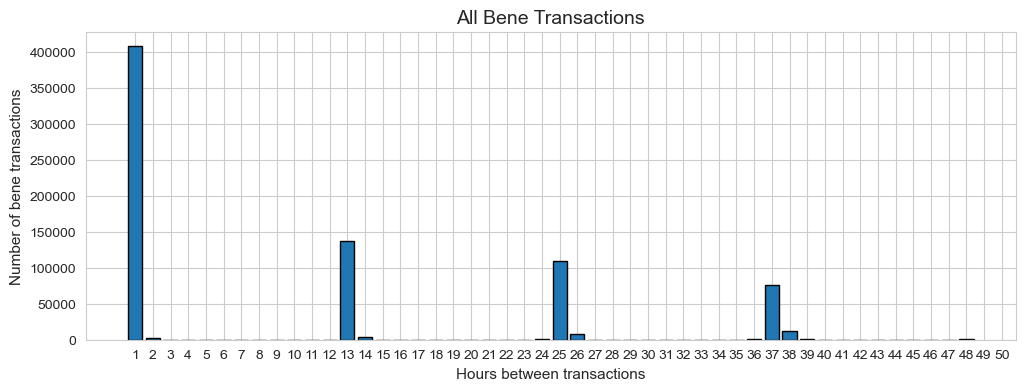

In [71]:
# Plotting distribution of bene fraud counts in hours after transaction
trans_btwn_all_bene_counts = np.zeros(48)

for i in np.arange(48):
    trans_btwn_all_bene_counts[i] = len(JPfraud[((JPfraud.bene_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.bene_time_btwn < dt.timedelta(hours=float(i+1))))])

plt.figure(figsize=(12,4))
plt.bar(np.linspace(1,48,48), trans_btwn_all_bene_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of bene transactions',fontsize=11)
plt.xticks(np.arange(50)+1)
plt.title('All Bene Transactions',fontsize=14)
plt.savefig('bene_hrs_btwn_all_transactions.png')
plt.show()

In [59]:
trans_btwn_bene_counts

array([2.842e+03, 5.500e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       1.284e+03, 1.190e+02, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       5.810e+02, 1.510e+02, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       3.890e+02, 1.580e+02, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00])

In [60]:
JPfraud.bene_time_btwn.describe()

count                       428512
mean     2 days 21:25:15.917407213
std      5 days 01:27:30.699188368
min                0 days 00:00:00
25%                0 days 00:10:00
50%                1 days 00:30:00
75%                3 days 12:50:00
max               57 days 13:00:00
Name: bene_time_btwn, dtype: object

In [61]:
# Number of fraud, bene transactions vs time between last transactions, 10-minute distribution (first 4 hours)
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('30min').Label.count().head(30)

bene_time_btwn
0 days 00:00:00    4271
0 days 00:30:00     280
0 days 01:00:00      50
0 days 01:30:00       5
0 days 02:00:00       1
0 days 02:30:00       0
0 days 03:00:00       0
0 days 03:30:00       0
0 days 04:00:00       0
0 days 04:30:00       0
0 days 05:00:00       0
0 days 05:30:00       0
0 days 06:00:00       0
0 days 06:30:00       0
0 days 07:00:00       0
0 days 07:30:00       0
0 days 08:00:00       0
0 days 08:30:00       0
0 days 09:00:00       0
0 days 09:30:00       0
0 days 10:00:00       0
0 days 10:30:00       0
0 days 11:00:00       1
0 days 11:30:00       0
0 days 12:00:00     894
0 days 12:30:00     390
0 days 13:00:00     102
0 days 13:30:00      17
0 days 14:00:00       5
0 days 14:30:00       0
Freq: 30min, Name: Label, dtype: int64

In [62]:
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('1D').Label.count()

bene_time_btwn
0 days     6018
1 days     1300
2 days      702
3 days      449
4 days      312
5 days      209
6 days      164
7 days      135
8 days      105
9 days       93
10 days      63
11 days      72
12 days      61
13 days      56
14 days      44
15 days      43
16 days      35
17 days      31
18 days      22
19 days      33
20 days      27
21 days      24
22 days      16
23 days      20
24 days      16
25 days      18
26 days      20
27 days      16
28 days      10
29 days       9
30 days       6
31 days      15
32 days      10
33 days      11
34 days       6
35 days       3
36 days       2
37 days       9
38 days       1
39 days       2
40 days       5
41 days       2
42 days       1
43 days       1
44 days       1
45 days       0
46 days       1
47 days       1
48 days       1
Freq: D, Name: Label, dtype: int64

In [63]:
JPfraud[JPfraud.Label == 0].set_index('bene_time_btwn').resample('1D').Label.count()

bene_time_btwn
0 days     250446
1 days      68442
2 days      45099
3 days      29569
4 days      22725
5 days      17585
6 days      12378
7 days       7597
8 days       4889
9 days       3759
10 days      3027
11 days      2643
12 days      2203
13 days      1928
14 days      1805
15 days      1484
16 days      1391
17 days      1282
18 days      1149
19 days      1104
20 days      1013
21 days       910
22 days       765
23 days       724
24 days       688
25 days       587
26 days       526
27 days       530
28 days       487
29 days       399
30 days       403
31 days       323
32 days       260
33 days       253
34 days       239
35 days       206
36 days       166
37 days       143
38 days       121
39 days        97
40 days       100
41 days        68
42 days        49
43 days        64
44 days        39
45 days        45
46 days        19
47 days        19
48 days        16
49 days        12
50 days         8
51 days         4
52 days         4
53 days         4
54 days      

In [64]:
timeDiffcompare = pd.concat([JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1D').Label.count(),
                             JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('1D').Label.count()],
                             keys=['sender_time_btwn','bene_time_btwn'],
                             axis=1).fillna(0)
timeDiffcompare.index = timeDiffcompare.index.days
timeDiffcompare

,sender_time_btwn,bene_time_btwn
0,6903.0,6018
1,1773.0,1300
2,642.0,702
3,346.0,449
4,155.0,312
5,109.0,209
6,74.0,164
7,44.0,135
8,33.0,105
9,24.0,93


<Figure size 2000x1000 with 0 Axes>

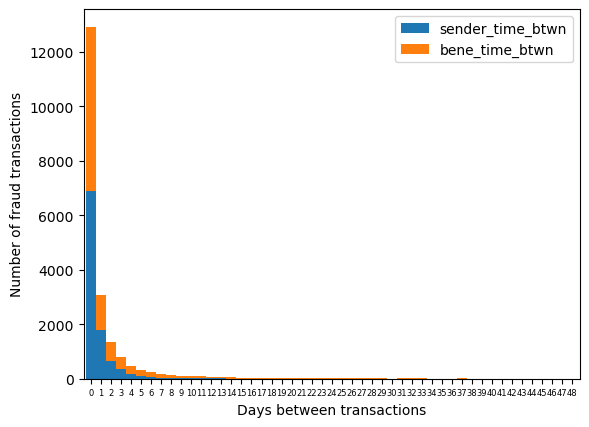

In [65]:
plt.figure(figsize=(20,10))
timeDiffcompare.plot.bar(stacked=True,width=1)
plt.xticks(fontsize=6,rotation=0)
plt.xlabel('Days between transactions')
plt.ylabel('Number of fraud transactions')
plt.show()

<font size=5> Generating time/time range features </font>

In [66]:
# Functions to convert between seconds and a time object
def convert_time_to_seconds(timeObj):
    return int((timeObj.hour)*60*60 + (timeObj.minute)*60 + (timeObj.second))

#def convert_seconds_to_time(seconds):
#    if pd.isna(seconds):
#        return pd.NA
#    
#    hour = int(seconds / 3600)
#    mins = int((seconds % 3600)/60)
#    secs = (seconds % 3600) % 60
#
#    return dt.time(hour,mins,secs)

In [67]:
np.linspace(0.75,1,26)

array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99, 1.  ])

In [68]:
pd.options.mode.chained_assignment = None
start = dt.datetime.now()

# Choosing quantile percentages
lower_time_quantile = 0.15
upper_time_quantile = 0.85

# seconds_in_day: time transaction occurred in seconds after midnight
JPfraud['seconds_in_day'] = JPfraud.timestamp.transform(lambda x: float(convert_time_to_seconds(x.time())))

# time_min_out: rolling lower quantile for range of time of SENDER transactions (in seconds after midnight)
JPfraud['time_min_out'] = (JPfraud.groupby('Sender_Account')['seconds_in_day']
                                  .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                    .quantile(q=lower_time_quantile,interpolation='midpoint'))
                                  .reset_index(level=0,drop=True)
                          )

# time_max_out: rolling upper quantile for range of time of SENDER transactions (in seconds after midnight)
JPfraud['time_max_out'] = (JPfraud.groupby('Sender_Account')['seconds_in_day']
                                  .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                    .quantile(q=upper_time_quantile,interpolation='midpoint'))
                                  .reset_index(level=0,drop=True)
                          )

# time_min_in: rolling lower quantile for range of time of BENEFICIARY transactions (in seconds after midnight)
JPfraud['time_min_in'] = (JPfraud.groupby('Bene_Account')['seconds_in_day']
                                 .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                   .quantile(q=lower_time_quantile,interpolation='midpoint'))
                                 .reset_index(level=0,drop=True)
                         )

# time_max_in: rolling upper quantile for range of time of BENEFICIARY transactions (in seconds after midnight)
JPfraud['time_max_in'] = (JPfraud.groupby('Bene_Account')['seconds_in_day']
                                 .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                   .quantile(q=upper_time_quantile,interpolation='midpoint'))
                                 .reset_index(level=0,drop=True)
                         )

# outside_time_bene_range:   indicator of whether transaction is outside range for beneficiary at
#                            time of transaction, 0 no, 1 yes
JPfraud = JPfraud.assign(outside_time_bene_range = lambda x: ((x.seconds_in_day < x.time_min_in) | (x.seconds_in_day > x.time_max_in))*1)

# outside_time_sender_range: indicator of whether transaction is outside usual time range for sender
#                            at time of transaction, 0 no, 1 yes
JPfraud = JPfraud.assign(outside_time_sender_range = lambda x: ((x.seconds_in_day < x.time_min_out) | (x.seconds_in_day > x.time_max_out))*1)

JPfraud

,timestamp_uniq,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,...,Transaction_Type,sender_time_btwn,bene_time_btwn,seconds_in_day,time_min_out,time_max_out,time_min_in,time_max_in,outside_time_bene_range,outside_time_sender_range
0,2022-03-15 10:24:00.000000000,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,...,WITHDRAWAL,0 days 00:00:00,NaT,37440.0,NaN,NaN,NaN,NaN,0,0
1,2022-03-15 10:24:00.000000001,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,...,QUICK-PAYMENT,0 days 00:00:00,0 days 00:00:00,37440.0,NaN,NaN,NaN,NaN,0,0
2,2022-03-15 10:24:00.000000002,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,...,DEPOSIT-CASH,NaT,0 days 00:00:00,37440.0,NaN,NaN,NaN,NaN,0,0
3,2022-03-15 10:24:00.000000003,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,...,PAY-CHECK,0 days 00:00:00,0 days 00:00:00,37440.0,NaN,NaN,NaN,NaN,0,0
4,2022-03-15 10:24:00.000000004,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,...,DEPOSIT-CHECK,NaT,0 days 00:00:00,37440.0,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2032-12-06 12:25:07.000099995,2032-12-06 12:25:07,PAYMENT-725414,JPMC-CLIENT-725133,ACCOUNT-725159,USA,49962.0,BILL-COMPANY-725415,ACCOUNT-725416,SAMOA,...,MAKE-PAYMENT,0 days 12:20:00,0 days 00:00:00,44707.0,19507.0,77407.0,NaN,NaN,0,0
499996,2032-12-06 14:55:07.000099996,2032-12-06 14:55:07,PAY-CHECK-722829,JPMC-CLIENT-722623,ACCOUNT-722636,USA,2054.0,CLIENT-722625,ACCOUNT-722633,USA,...,PAY-CHECK,0 days 12:00:00,0 days 12:00:00,53707.0,6907.0,81007.0,26107.0,78307.0,0,0
499997,2032-12-06 15:05:07.000099997,2032-12-06 15:05:07,MAKE-PAYMENT-722830,JPMC-CLIENT-722623,ACCOUNT-722637,USA,39197.0,CLIENT-722625,ACCOUNT-722633,USA,...,MAKE-PAYMENT,1 days 12:10:00,0 days 00:10:00,54307.0,26107.0,79507.0,26107.0,78307.0,0,0
499998,2032-12-06 15:15:07.000099998,2032-12-06 15:15:07,QUICK-PAYMENT-722831,JPMC-CLIENT-722623,ACCOUNT-722636,USA,9106.0,CLIENT-722625,ACCOUNT-722633,USA,...,QUICK-PAYMENT,0 days 00:20:00,0 days 00:10:00,54907.0,9007.0,76507.0,27007.0,76207.0,0,0


In [69]:
time_features = JPfraud[['timestamp','Label','seconds_in_day','outside_time_bene_range','outside_time_sender_range']]
time_features

,timestamp,Label,seconds_in_day,outside_time_bene_range,outside_time_sender_range
0,2022-03-15 10:24:00,0,37440.0,0,0
1,2022-03-15 10:24:00,0,37440.0,0,0
2,2022-03-15 10:24:00,0,37440.0,0,0
3,2022-03-15 10:24:00,0,37440.0,0,0
4,2022-03-15 10:24:00,0,37440.0,0,0
...,...,...,...,...,...
499995,2032-12-06 12:25:07,0,44707.0,0,0
499996,2032-12-06 14:55:07,0,53707.0,0,0
499997,2032-12-06 15:05:07,0,54307.0,0,0
499998,2032-12-06 15:15:07,0,54907.0,0,0


In [70]:
def label_time_range(seconds):
    return int(seconds/3600) + 1

In [71]:
# transaction_hour: hour of transaction within a day
time_features['transaction_hour'] = time_features.seconds_in_day.apply(label_time_range)
time_features

,timestamp,Label,seconds_in_day,outside_time_bene_range,outside_time_sender_range,transaction_hour
0,2022-03-15 10:24:00,0,37440.0,0,0,11
1,2022-03-15 10:24:00,0,37440.0,0,0,11
2,2022-03-15 10:24:00,0,37440.0,0,0,11
3,2022-03-15 10:24:00,0,37440.0,0,0,11
4,2022-03-15 10:24:00,0,37440.0,0,0,11
...,...,...,...,...,...,...
499995,2032-12-06 12:25:07,0,44707.0,0,0,13
499996,2032-12-06 14:55:07,0,53707.0,0,0,15
499997,2032-12-06 15:05:07,0,54307.0,0,0,16
499998,2032-12-06 15:15:07,0,54907.0,0,0,16


In [72]:
(time_features[time_features.Label == 1].outside_time_bene_range.sum() +
time_features[time_features.Label == 1].outside_time_sender_range.sum())/len(time_features[time_features.Label == 1])

np.float64(0.610626409175571)

In [73]:
(time_features.outside_time_bene_range.sum() + time_features.outside_time_sender_range.sum())/len(time_features)

np.float64(0.57022)

In [74]:
#time_features.to_csv('data/time_features.csv')

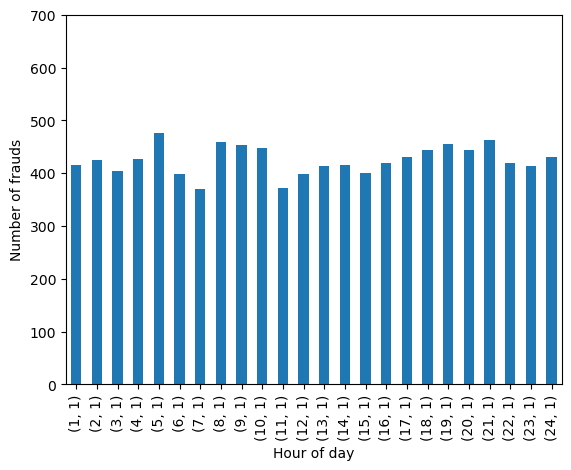

In [75]:
time_features[time_features.Label == 1].groupby('transaction_hour').Label.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of frauds')
plt.ylim([0,700])
plt.show()

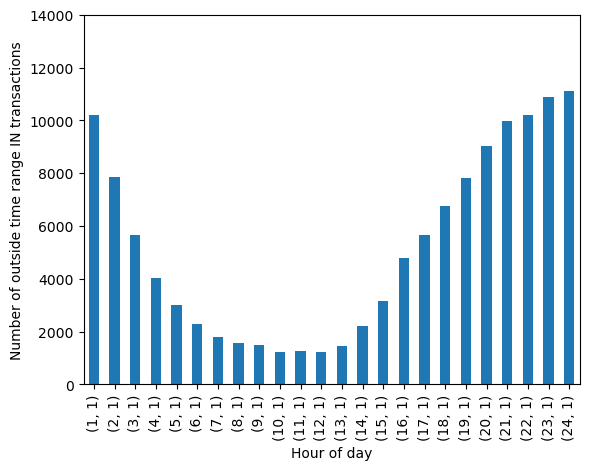

In [76]:
time_features[time_features.outside_time_bene_range == 1].groupby('transaction_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range IN transactions')
plt.ylim([0,14000])
plt.show()

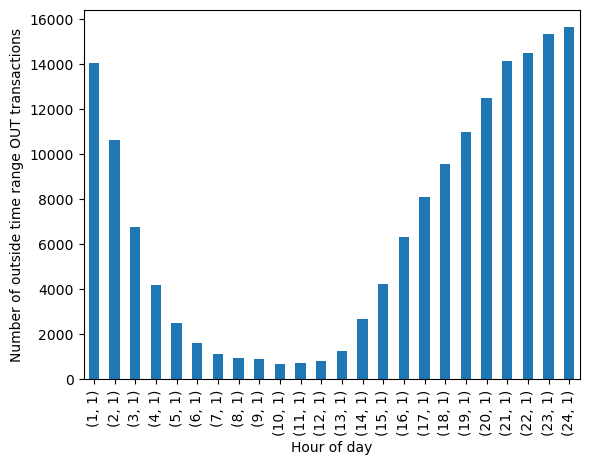

In [77]:
time_features[time_features.outside_time_sender_range == 1].groupby('transaction_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range OUT transactions')
#plt.ylim([0,14000])
plt.show()

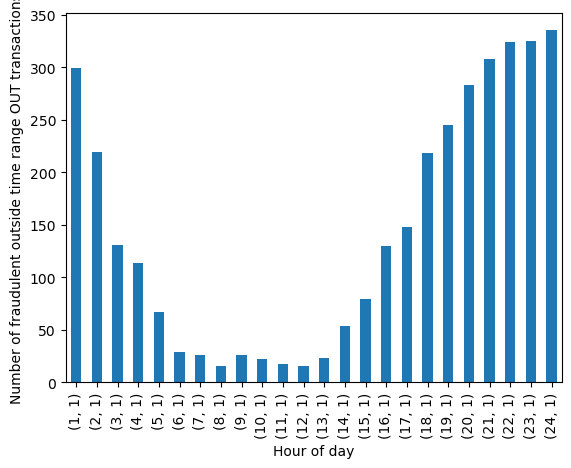

In [78]:
time_features[((time_features.outside_time_sender_range == 1) & (time_features.Label == 1))].groupby(
    'transaction_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range OUT transactions')
#plt.ylim([0,14000])
plt.show()

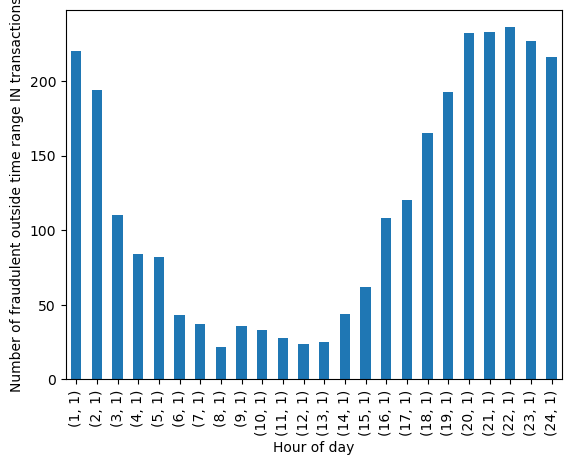

In [79]:
time_features[((time_features.outside_time_bene_range == 1) & (time_features.Label == 1))].groupby(
    'transaction_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range IN transactions')
#plt.ylim([0,14000])
plt.show()

In [80]:
#JPfraud.loc[JPfraud.Sender_Id == sendIDs[9]].USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].values

In [81]:
pd.options.mode.chained_assignment = None

In [82]:
#sender_fraud_stat_amounts = JPfraud.loc[JPfraud.Label == 1].groupby(
#    'Sender_Id').USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].reset_index()
#sender_fraud_stat_amounts

In [83]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].outside_time_bene_range.sum()

np.int64(14)

In [84]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].Label.sum()

np.int64(3)

In [85]:
JPfraud[JPfraud.Sender_Account == 'ACCOUNT-9825']

,timestamp_uniq,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,...,Transaction_Type,sender_time_btwn,bene_time_btwn,seconds_in_day,time_min_out,time_max_out,time_min_in,time_max_in,outside_time_bene_range,outside_time_sender_range
3,2022-03-15 10:24:00.000000003,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,...,PAY-CHECK,0 days 00:00:00,0 days 00:00:00,37440.0,NaN,NaN,NaN,NaN,0,0
137,2022-03-15 10:54:00.000000137,2022-03-15 10:54:00,PAY-BILL-9836,JPMC-CLIENT-9812,ACCOUNT-9825,USA,2871.0,COMPANY-9815,ACCOUNT-9821,USA,...,MAKE-PAYMENT,0 days 00:30:00,0 days 00:00:00,39240.0,NaN,NaN,NaN,NaN,0,0
365,2022-03-16 23:24:00.000000365,2022-03-16 23:24:00,CASH-CHECK-9843,JPMC-CLIENT-9812,ACCOUNT-9825,USA,16185.0,NaN,NaN,NaN,...,EXCHANGE,1 days 12:30:00,NaT,84240.0,38340.0,61740.0,NaN,NaN,0,1
442,2022-03-17 11:34:00.000000442,2022-03-17 11:34:00,QUICK-PAYMENT-9842,JPMC-CLIENT-9812,ACCOUNT-9825,USA,30716.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,...,QUICK-PAYMENT,0 days 12:10:00,1 days 12:10:00,41640.0,38340.0,62940.0,39540.0,62940.0,0,0
517,2022-03-17 23:34:00.000000517,2022-03-17 23:34:00,WITHDRAWAL-9845,JPMC-CLIENT-9812,ACCOUNT-9825,USA,2041.0,NaN,NaN,NaN,...,EXCHANGE,0 days 12:00:00,NaT,84840.0,38340.0,84540.0,NaN,NaN,0,1
525,2022-03-17 23:44:00.000000525,2022-03-17 23:44:00,PAY-BILL-9846,JPMC-CLIENT-9812,ACCOUNT-9825,USA,11960.0,COMPANY-9815,ACCOUNT-9821,USA,...,MAKE-PAYMENT,0 days 00:10:00,2 days 12:50:00,85440.0,38340.0,85140.0,NaN,NaN,0,1
753,2022-03-19 13:14:00.000000753,2022-03-19 13:14:00,QUICK-PAYMENT-9865,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38842.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,...,QUICK-PAYMENT,1 days 13:30:00,0 days 00:10:00,47640.0,38340.0,85140.0,39540.0,65940.0,0,0
755,2022-03-19 13:24:00.000000755,2022-03-19 13:24:00,EXCHANGE-9866,JPMC-CLIENT-9812,ACCOUNT-9825,USA,19558.0,NaN,NaN,NaN,...,EXCHANGE,0 days 00:10:00,NaT,48240.0,40440.0,84540.0,NaN,NaN,0,0
759,2022-03-19 13:54:00.000000759,2022-03-19 13:54:00,MOVE-FUNDS-9869,JPMC-CLIENT-9812,ACCOUNT-9825,USA,13635.0,JPMC-COMPANY-9819,ACCOUNT-9830,LIBERIA,...,MOVE-FUNDS,0 days 00:30:00,0 days 00:00:00,50040.0,40440.0,84540.0,NaN,NaN,0,0
760,2022-03-19 14:04:00.000000760,2022-03-19 14:04:00,EXCHANGE-9870,JPMC-CLIENT-9812,ACCOUNT-9825,USA,34203.0,NaN,NaN,NaN,...,WITHDRAWAL,0 days 00:10:00,NaT,50640.0,40440.0,84540.0,NaN,NaN,0,0


<font size=5> Adding Abdullah's features to test run a logistic model on training data</font>

In [ ]:
JPfraud_fit = JPfraud[:465008].loc[JPfraud.USD_amount > 0].reset_index(drop=True)
JPfraud_fit

In [ ]:
# columns to drop for model fitting
columns_to_drop = ['seconds_in_day','time_min_in','time_max_in','time_min_out','time_max_out',
                   'rolling_sender_trans_min','rolling_sender_trans_max','rolling_bene_trans_min',
                   'rolling_bene_trans_max','rolling_sender_time_diff_min','rolling_sender_time_diff_max',
                   'rolling_bene_time_diff_min','rolling_bene_time_diff_max','sender_time_btwn','bene_time_btwn',
                   'timestamp','Transaction_Id','Sender_Id','Sender_Account','Sender_Country','Bene_Id',
                   'USD_amount','Bene_Account','Bene_Country','Transaction_Type']

In [ ]:
JPfraud_fit = JPfraud_fit.drop(labels=columns_to_drop,axis=1)
JPfraud_fit

In [ ]:
more_features = pd.read_csv('../data/Total_engineered_features')
more_features

In [ ]:
more_features = more_features.drop(columns=['Quick'])

In [ ]:
JPfraud_fit = pd.concat([JPfraud_fit,more_features],axis=1)
JPfraud_fit

In [ ]:
JPfraud_fit.columns

In [ ]:
num_features = ['bene_prob','Fraud_percentage_bene','Fraud_index_bene','sender_prob',
                'Fraud_percentage_sender','Fraud_index_sender']
cat_features = ['out_sender_trans_range','out_bene_trans_range','out_sender_time_diff_range',
                'out_bene_time_diff_range','outside_time_bene_range','outside_time_sender_range','New',
                'Repeat_Fraud','Quick','Transaction_Type_DEPOSIT-CASH','Transaction_Type_DEPOSIT-CHECK',
                'Transaction_Type_EXCHANGE','Transaction_Type_MAKE-PAYMENT', 'Transaction_Type_MOVE-FUNDS',
                'Transaction_Type_PAY-CHECK','Transaction_Type_QUICK-PAYMENT','Transaction_Type_WITHDRAWAL']

In [ ]:
print(len(JPfraud_fit.columns))
print(len(num_features))
print(len(cat_features))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, classification_report, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(JPfraud_fit.drop(columns=['Label'],axis=1),JPfraud_fit.Label,test_size=0.2,random_state=12345)

In [ ]:
log_reg = LogisticRegression()
y = JPfraud_fit.Label

log_reg.fit(X_train,y_train)
Label_preds = log_reg.predict(X_test)

print('Coeffs: ',log_reg.coef_)
print('Intercept: ', log_reg.intercept_)
print('Score: ', log_reg.score(JPfraud_fit.drop(labels=['Label'],axis=1),y))
print(classification_report(y_test, Label_preds))

In [ ]:
confusion_matrix(y_test,Label_preds, normalize='true').round(3)

In [ ]:
cm = confusion_matrix(y_test, Label_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix')
plt.show()

In [91]:
total_features = pd.read_csv('../data/total_features')
total_features

,bene_prob,Fraud_percentage_bene,Fraud_index_bene,Fraud_centrality_bene,bene_in_deg,bene_out_deg,fraud_rate_by_country_bene,sender_prob,Fraud_percentage_sender,Fraud_index_sender,...,fraud_rate_by_country_sender,Repeat_Fraud,fraud_rate_by_sector,DEPOSIT-CHECK,EXCHANGE,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT,WITHDRAWAL
0,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,0,0,1
1,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,0,1,0
2,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,1,0,0
4,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,0.958891,0.000000,1.000000e-08,0.000000,1.0,1.0,0.020571,0.301462,0.000000,1.000000e-08,...,0.020571,False,0.020571,0,0,1,0,0,0,0
1498151,0.193204,0.076923,1.000000e+00,0.135135,9.0,4.0,0.020571,0.264044,0.075188,1.000000e+00,...,0.020571,False,0.020571,0,0,0,0,0,1,0
1498152,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.020571,0.055998,0.000000,1.000000e-08,...,0.020571,False,0.020571,0,0,1,0,0,0,0
1498153,0.694375,0.071429,1.000000e+00,0.135135,10.0,4.0,0.020571,0.792519,0.074627,1.000000e+00,...,0.020571,False,0.020571,0,0,0,0,0,1,0


In [93]:
len(total_features.columns)

23

In [94]:
total_features.columns

Index(['bene_prob', 'Fraud_percentage_bene', 'Fraud_index_bene',
       'Fraud_centrality_bene', 'bene_in_deg', 'bene_out_deg',
       'fraud_rate_by_country_bene', 'sender_prob', 'Fraud_percentage_sender',
       'Fraud_index_sender', 'Fraud_centrality_sender', 'sender_in_deg',
       'sender_out_deg', 'fraud_rate_by_country_sender', 'Repeat_Fraud',
       'fraud_rate_by_sector', 'DEPOSIT-CHECK', 'EXCHANGE', 'MAKE-PAYMENT',
       'MOVE-FUNDS', 'PAY-CHECK', 'QUICK-PAYMENT', 'WITHDRAWAL'],
      dtype='object')

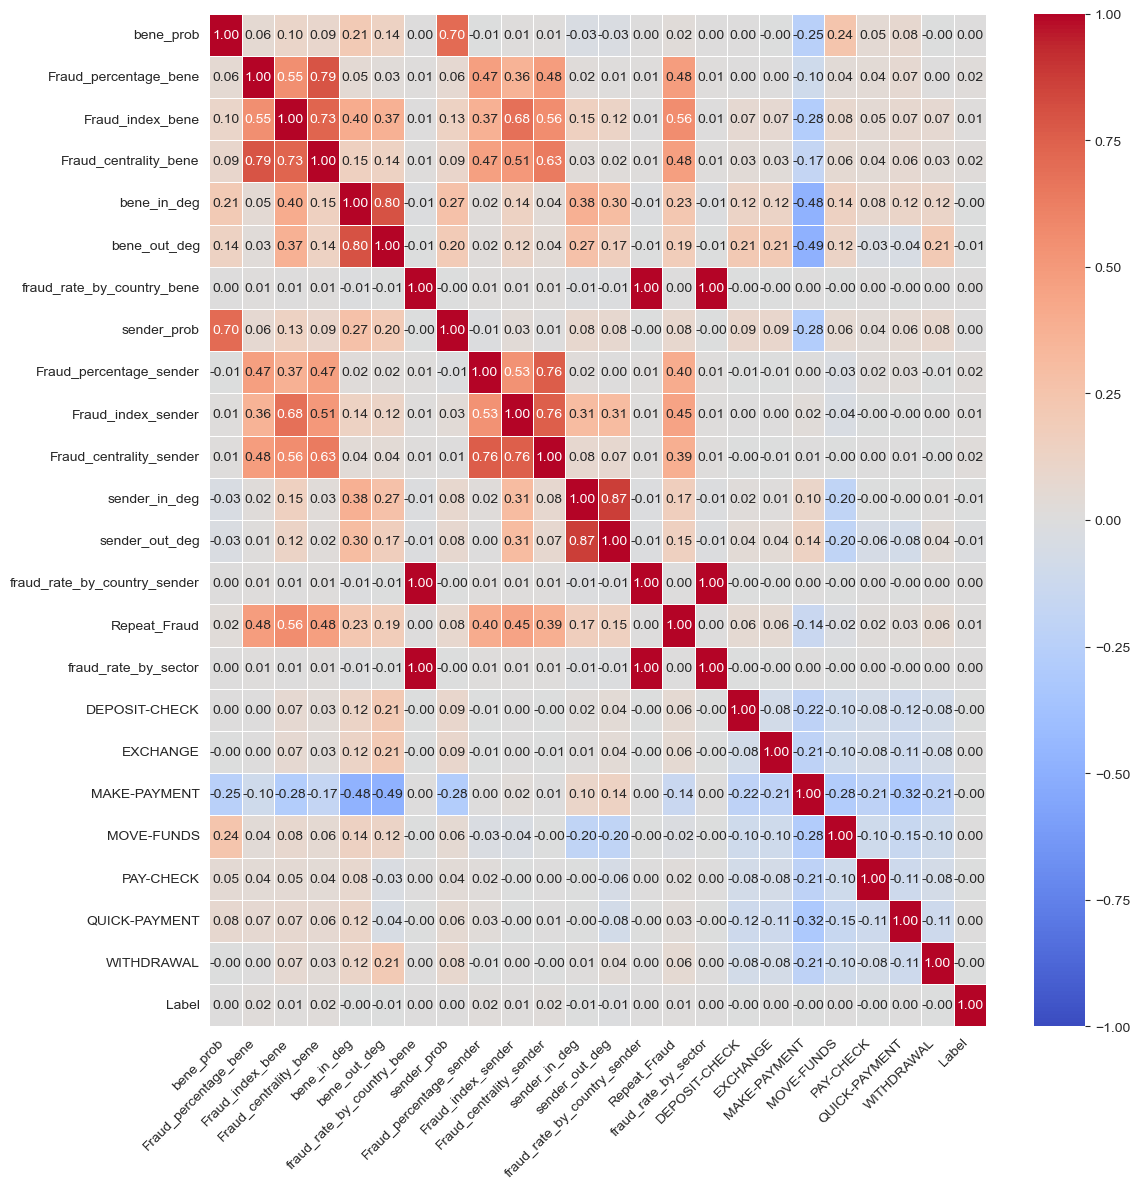

In [128]:
plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(pd.concat([total_features,JPfraud_full['Label']],axis=1).corr(),
        annot=True,         # Display correlation values on the heatmap
        cmap='coolwarm',    # Choose a divergent colormap (e.g., 'coolwarm', 'RdBu')
        fmt=".2f",          # Format annotation values to two decimal places
        linewidths=.5,      # Add lines between cells
        cbar=True,          # Display the color bar
        vmin=-1,            # Set the minimum value for the color scale
        vmax=1              # Set the maximum value for the color scale
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_corr_matrix.png')
plt.show()